In [69]:
!pip install emoji

In [116]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
import os

# data processing 
import re, string 
import emoji
import nltk
from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [71]:
#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

# 1. Loading the data

In [72]:
df = pd.read_csv('/content/drive/MyDrive/data/coronavirus_tweets/Corona_NLP_train.csv',encoding='ISO-8859-1')

In [73]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [74]:
df_test = pd.read_csv('/content/drive/MyDrive/data/coronavirus_tweets/Corona_NLP_test.csv')

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


We convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis

In [76]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

How about duplicate tweets ?

In [77]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


--> We have no duplicate

But to simplify the problem to study, I just want to keep the columns 'Originaltweet' (raw tweet) and the target column 'Sentiment'

In [79]:
df = df[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

# 2. Preprocessing

In [80]:
def preprocess_text(text):
    # Clean emojis from texts
    text = re.sub(emoji.get_emoji_regexp(), r"", text)

    # Remove links and mentions
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)

    # Remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    # html_pattern = re.compile(r'<[^<>]+>')
    # text = html_pattern.sub(" ", text)
    
    # Remove last hashtags
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))

    # Remove punctuations
    replace_chars = ["\n", "\t", "\r"] + list(string.punctuation)
    for char in replace_chars:
        text = text.replace(char, " ")

    # Remove hashtags symbol from words in the middle of the sentence
    text = " ".join(word.strip() for word in re.split('#|_', text))
    text = text.split()
    text = " ".join(text)

    return text.lower()

In [81]:
texts_new = [preprocess_text(x) for x in df.OriginalTweet]
texts_new_test = [preprocess_text(x) for x in df_test.OriginalTweet]

In [82]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [83]:
df['text_clean'][100]

'i hate grocery shopping in general but i swear im doing it online next shop can not deal with the swathes of panic buyers at all covid 19'

In [84]:
df['OriginalTweet'][100]

'I hate grocery shopping in general but I swear IÂ\x92m doing it online next shop, can not deal with the swathes of panic buyers at all! #COVID?19 #coronavirus #coronavirusuk #anxiety #panicbuyinguk #morons'

In [85]:
# Add a column to control the length of the clean text
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [86]:
df['text_len'] = text_len

In [87]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [88]:
df_test['text_len'] = text_len_test

In [89]:
df['text_len']

0         2
1        38
2        14
3        35
4        37
         ..
41152    10
41153    23
41154    16
41155    15
41156    49
Name: text_len, Length: 41157, dtype: int64

In [90]:
# Because there are some tweets with only hashtag, mentions and links so we need to remove them
df = df[df['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]

In [91]:
df.shape, df_test.shape

((40748, 4), (3783, 4))

In [92]:
# Process labels

In [93]:
df['Sentiment'].value_counts()

Positive              11333
Negative               9871
Neutral                7459
Extremely Positive     6613
Extremely Negative     5472
Name: Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [94]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [95]:
df['Sentiment'].value_counts()

2    17946
0    15343
1     7459
Name: Sentiment, dtype: int64

In [102]:
df_test['Sentiment'].value_counts()

0    1632
2    1543
1     608
Name: Sentiment, dtype: int64

# 3. EDA

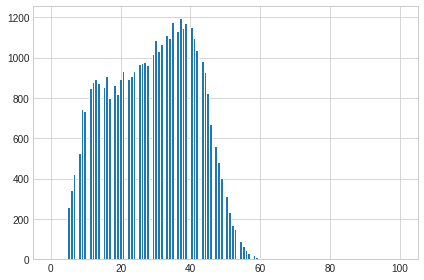

In [96]:
plt.hist([len(t.split()) for t in df['text_clean']], bins=128, range=(0, 100))
plt.show()

In [97]:
max_length = 40 

In [98]:
word_list = []
[[word_list.append(word) for word in sent.split()] for sent in df['text_clean']]
vocab = Counter(word_list)
len(vocab), len(word_list)

(38704, 1176709)

In [99]:
freq_word = []
for i in range(10):
  num = len([word for word,freq in vocab.items() if freq==i])
  freq_word.append(num)
freq_word

[0, 19443, 5039, 2509, 1557, 1053, 832, 626, 565, 492]

In [100]:
df['Sentiment']

1        2
2        2
3        2
4        0
5        2
        ..
41152    1
41153    0
41154    2
41155    1
41156    0
Name: Sentiment, Length: 40748, dtype: int64

# 4. Split dataset 

In [103]:
train_sentences, valid_sentences, train_labels, valid_labels = train_test_split(
                                                                df['text_clean'], df['Sentiment'], 
                                                                test_size=0.3, random_state=42)

In [104]:
test_sentences, test_labels = df_test['text_clean'], df_test['Sentiment']

In [105]:
len(train_sentences), len(valid_sentences), len(test_sentences)

(28523, 12225, 3783)

In [106]:
len(train_labels), len(valid_labels), len(test_labels)

(28523, 12225, 3783)

# 5. Text Representation

In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [108]:
vocab_size = 20000
max_length = 40
embedding_dim = 300

In [109]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

In [111]:
tokenizer.index_word

{1: '<OOV>',
 2: 'the',
 3: 'to',
 4: 'and',
 5: 'of',
 6: 'a',
 7: 'in',
 8: 'for',
 9: '19',
 10: 'covid',
 11: 'is',
 12: 'are',
 13: 'i',
 14: 'you',
 15: 'on',
 16: 'coronavirus',
 17: 'this',
 18: 'prices',
 19: 'at',
 20: 'food',
 21: 'store',
 22: 'supermarket',
 23: 'it',
 24: 'with',
 25: 'we',
 26: 'that',
 27: 'grocery',
 28: 'have',
 29: 'as',
 30: 'be',
 31: 's',
 32: 'people',
 33: 'from',
 34: 'amp',
 35: 'all',
 36: 'your',
 37: 'not',
 38: 'will',
 39: 'consumer',
 40: 'my',
 41: 'can',
 42: 'they',
 43: 'our',
 44: 'out',
 45: 'up',
 46: 'or',
 47: 'has',
 48: 'by',
 49: 'more',
 50: 'if',
 51: 't',
 52: 'but',
 53: 'shopping',
 54: 'online',
 55: 'their',
 56: 'how',
 57: 'during',
 58: 'so',
 59: 'now',
 60: 'no',
 61: 'get',
 62: 'pandemic',
 63: 'what',
 64: 'about',
 65: 'who',
 66: 'need',
 67: 'workers',
 68: 'just',
 69: 'panic',
 70: 'was',
 71: 'us',
 72: 'do',
 73: 'like',
 74: 'time',
 75: 'go',
 76: 'an',
 77: 'there',
 78: 'home',
 79: 'sanitizer',
 80:

In [112]:
train_seq = tokenizer.texts_to_sequences(train_sentences)
train_seq_pad = pad_sequences(train_seq, maxlen=max_length, truncating='post', padding="post") #padding: "pre"

valid_seq = tokenizer.texts_to_sequences(valid_sentences)
valid_seq_pad = pad_sequences(valid_seq, maxlen=max_length, truncating='post', padding="post")

test_seq = tokenizer.texts_to_sequences(test_sentences)
test_seq_pad = pad_sequences(test_seq, maxlen=max_length, truncating='post', padding="post")

In [113]:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

In [114]:
train_labels.shape

(28523,)

# 6.  Embedding + Neural Network

In [ ]:
import tensorflow as tf

In [117]:
checkpoint_path = "/content/save_model/model_nn.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [119]:
model_nn = tf.keras.Sequential()
model_nn.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model_nn.add(tf.keras.layers.Flatten())
model_nn.add(tf.keras.layers.Dense(10, activation='relu'))
model_nn.add(tf.keras.layers.Dense(3, activation='softmax'))
model_nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn.summary()
history = model_nn.fit(train_seq_pad, train_labels, epochs=20, validation_data=(valid_seq_pad, valid_labels), callbacks=[model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           6000000   
                                                                 
 flatten (Flatten)           (None, 12000)             0         
                                                                 
 dense (Dense)               (None, 10)                120010    
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 6,120,043
Trainable params: 6,120,043
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
892/892 [==============================] - ETA: 0s - loss: 0.7728 - accuracy: 0.6367
Epoch 00001: val_accuracy improved from -inf to 0.77628, saving model to /content/

In [131]:
model_nn.load_weights(checkpoint_path)
test_predict = model_nn.predict(test_seq_pad)
test_predict = np.argmax(test_predict, axis=1)
confusion_matrix(test_labels, test_predict)
print("Accuracy:", accuracy_score(test_labels, test_predict))
print(classification_report(test_labels, test_predict))

Accuracy: 0.7642083002907745
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1632
           1       0.68      0.63      0.65       608
           2       0.76      0.82      0.79      1543

    accuracy                           0.76      3783
   macro avg       0.75      0.74      0.74      3783
weighted avg       0.76      0.76      0.76      3783



In [130]:
test_predict

array([0, 2, 2, ..., 0, 0, 2])

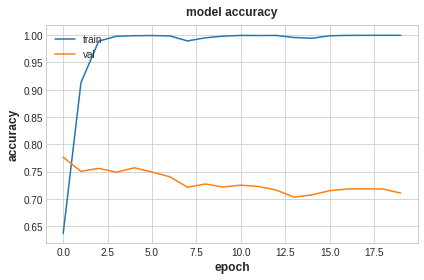

In [125]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [138]:
test_sentence = "Many developed countries are showing ever stronger resolve to vaccinate their public against #COVID19"
test = tokenizer.texts_to_sequences([preprocess_text(test_sentence)])
padded_test = pad_sequences(test, maxlen=max_length, truncating="post", padding="post")
model_nn.predict(padded_test)

array([[0.36299488, 0.18340936, 0.4535958 ]], dtype=float32)